# Time Series Forecasting Model - REPL
This notebook demonstrates time series forecasting using the `TSFM` library.
You'll see how the registry pattern attached to `Model` lets you swap models with a single line of code, and how the shared `ForecastOutput` wrapper standardizes evaluation and visualization.

- **Goal:** demonstrate the end-to-end workflow for forecasting monthly macroeconomic data with `tsfm`.
- **What you'll learn:** data ingestion, simulator usage, model registry, evaluation helpers, and visualization.
- **Tip:** feel free to swap models or targets to experiment.

## 1. Import Libraries

We'll rely on standard scientific Python tools alongside the `tsfm` package. The `Model` registry lets us dynamically build forecasting backends by name, so importing it is enough to access every registered model.

> **Cheat sheet**: `Model` is the abstract base class; concrete implementations like `armodel` and `moirai` register themselves so you can instantiate them by string name. Utilities in `tsfm.data` help you simulate or prepare data, and `tsfm.outputs.ForecastOutput` standardizes evaluation metrics and plots.

In [11]:
import pandas as pd

from tsfm import Model

## 2. Load and Prepare Data

We'll start from the provided macroeconomic panel. We coerce the index to month-end timestamps so every model sees the same calendar. Feel free to swap in your own DataFrame, as long as the index is a ordered (from past to recent) `DatetimeIndex`, the downstream helpers will work unchanged.

In [12]:
cols_to_drop = "Negotiated wages including"
df = pd.read_csv("data/data.csv").dropna().rename(columns={"Unnamed: 0": "dt"})
df["dt"] = pd.to_datetime(df["dt"], format="%Y%b").add(pd.offsets.MonthEnd(0))
df.index = df.pop("dt")
df = df.drop(cols_to_drop, axis=1).astype(float).sort_index()

### Peek at the panel

In [13]:
display(df.head())
df.describe().T.assign(non_null=df.notna().sum(), missing=df.isna().sum())

,Negotiated wages excluding,HICP overall index,Price trends over next 12 months,Economic sentiment,Unemployment expectation over the next 12 months,Unemployment rate,Industrial production
dt,,,,,,,
1992-01-31,8.93,68.90,57.8,94.1,33.1,6.019721,81.1
1992-02-29,8.67,69.14,60.0,93.2,34.8,6.086864,81.9
1992-03-31,7.46,69.42,59.8,90.6,36.7,6.171593,80.0
1992-04-30,9.68,69.66,61.9,88.6,38.9,6.276541,79.9
1992-05-31,12.42,69.84,63.0,87.5,40.3,6.393789,79.0


,count,mean,std,min,25%,50%,75%,max,non_null,missing
Negotiated wages excluding,403.0,2.753474,1.817749,0.500000,1.860000,2.310000,2.860000,12.420000,403,0
HICP overall index,403.0,92.588015,15.829927,68.900000,78.650000,91.400000,101.700000,131.900000,403,0
Price trends over next 12 months,403.0,36.437221,13.126842,-0.100000,26.050000,35.900000,45.600000,66.700000,403,0
Economic sentiment,403.0,98.980397,10.285056,66.800000,92.250000,101.000000,106.500000,118.300000,403,0
Unemployment expectation over the next 12 months,403.0,29.111166,17.246149,-2.800000,16.200000,26.700000,42.900000,78.400000,403,0
Unemployment rate,403.0,6.551615,2.541322,2.857827,3.836402,7.080518,8.546397,11.237894,403,0
Industrial production,403.0,91.895782,11.029378,69.800000,82.950000,93.500000,101.800000,111.100000,403,0


### Visualize the target

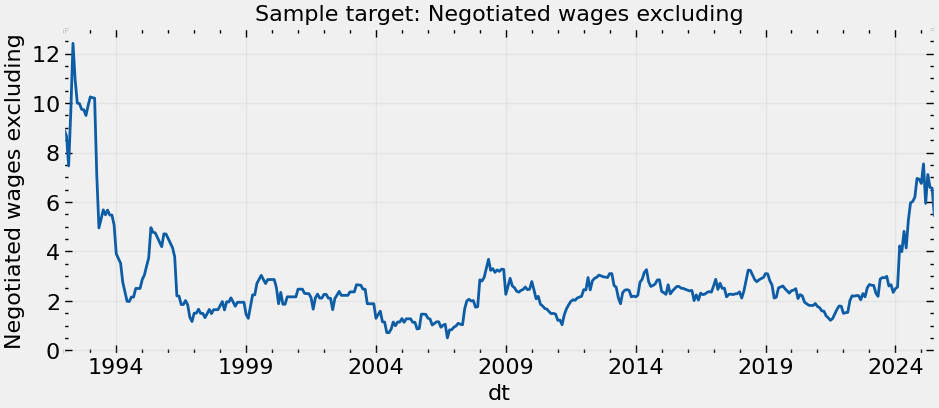

In [14]:
target = df.columns[0]
ax = df[target].plot(figsize=(10, 4), title=f"Sample target: {target}")
ax.set_ylabel(target)
ax.grid(True, alpha=0.3)

## 3. (Optional) Simulate synthetic data

If you want to experiment without the macro panel, the `tsfm.data.generator` function can synthesize autoregressive monthly data with trend and seasonality. The helper returns a tidy DataFrame ready for any model.

In [ ]:
from tsfm.data import generator, split_is_oos

synthetic = generator(n=120, seed=42)
syn_is, syn_oos = split_is_oos(synthetic, test_frac=0.2)
syn_is.tail(), syn_oos.head()

(                   x         y
 2007-08-31 -0.423298  1.278021
 2007-09-30 -0.079718  0.330093
 2007-10-31 -1.687334  0.440215
 2007-11-30 -1.447112  0.066509
 2007-12-31 -1.322700  1.248471,
                    x         y
 2008-01-31 -0.997247  1.293991
 2008-02-29  0.399774  1.956589
 2008-03-31 -0.905479  2.802947
 2008-04-30 -0.378163  3.609860
 2008-05-31  1.299228  4.749641)

## 4. Build Models and Generate Predictions

The `Model.build()` factory consults the registry populated by each subclass. We'll start with Salesforce's `moirai` foundation model, which supports covariates and longer horizons. You can swap the `mdl_name` to `armodel` for a lightweight autoregressive baseline.

### Forecast with the Moirai foundation model

Moirai handles multivariate contexts and longer horizons. We select a target column, pass the remaining columns as covariates, and request a 12-month forecast horizon starting in 2020.

In [ ]:
mdl_name = "moirai" # "armodel" "moirai" "moirai2"
mdl = Model.build(name=mdl_name)

y = "Negotiated wages excluding"
X = list(df.columns[1:])
oos_start = "2020-01-31"
res = mdl.pred(df=df, y=y, X=X, ctx_len=100, horizon=12, oos_start=oos_start)

### Baseline forecast with the autoregressive model

For a fast baseline, the `armodel` implementation trains a rolling autoregressive process $AR(1)$ of order `ctx_len`. It only consumes the target column, so we set `X=None` and keep a short context window.

In [18]:
arm = Model.build(name="armodel")
arm_res = arm.pred(df=df[[y]].copy(), y=y, X=None, ctx_len=4, horizon=6, oos_start=oos_start)
arm_res.summary()

================== Forecast Results Summary ==================
Observations: 372
Cutoff range : 2019-12-31  -  2025-01-31
OOS range    : 2020-01-31  -  2025-07-31
Horizons     : 1, 2, 3, 4, 5, 6
Meta         : model=armodel | oos_start=2020-01-31
--------------------------------------------------------------
         rmsfe    mae     me
horizon                     
1       0.4396 0.2656 0.1015
2       0.5807 0.3838 0.1947
3       0.7884 0.5254 0.3016
4       0.9408 0.6400 0.3882
5       1.0871 0.7236 0.4752
6       1.2037 0.7819 0.5297
average 0.8400 0.5534 0.3318


## 5. Analyze Results

Every forecast returns a `ForecastOutput`. It stores the multi-horizon panel in `df_preds` and offers cached metrics so you can compare models quickly. Below we print the text summary and then pull metric tables directly for ad-hoc analysis.

In [19]:
res.summary()

================== Forecast Results Summary ==================
Observations: 672
Cutoff range : 2019-12-31  -  2024-07-31
OOS range    : 2020-01-31  -  2025-07-31
Horizons     : 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Meta         : model=moirai | oos_start=2020-01-31
--------------------------------------------------------------
         rmsfe    mae     me
horizon                     
1       0.4103 0.2505 0.0522
2       0.5544 0.3672 0.1092
3       0.7255 0.5058 0.1717
4       0.8593 0.6256 0.2390
5       1.0001 0.6980 0.3015
6       1.1326 0.7805 0.3798
7       1.2497 0.8528 0.4701
8       1.3357 0.9015 0.5021
9       1.4900 1.0289 0.6259
10      1.6694 1.1478 0.7337
11      1.7449 1.2451 0.7988
12      1.8618 1.3227 0.8909
average 1.1695 0.8105 0.4396


### Compare metrics side by side

Each metric is a cached property. You can access them individually or stack them for comparison. The example below collects MAE and RMSFE for both models to benchmark alternatives.

In [20]:
metrics = pd.concat({"moirai": res.mae["mae"], "armodel": arm_res.mae["mae"]}, axis=1)
metrics.index.name = "horizon"
metrics

,moirai,armodel
horizon,,
1,0.250528,0.265615
2,0.367208,0.383792
3,0.505764,0.525381
4,0.625583,0.640048
5,0.697967,0.723597
6,0.780511,0.781941
7,0.852840,NaN
8,0.901472,NaN
9,1.028851,NaN


### Inspect the underlying forecast panel

`ForecastOutput.df_preds` is a tidy MultiIndex DataFrame keyed by cutoff and out-of-sample date. This makes it easy to filter by horizon or time slices.

In [21]:
res.df_preds.head()

y_true    y_pred
cutoff     oos_date                    
2019-12-31 2020-01-31    2.41  2.467675
           2020-02-29    2.43  2.515745
           2020-03-31    2.49  2.539232
           2020-04-30    2.09  2.537055
           2020-05-31    2.25  2.548282

### Plot a specific horizon

`ForecastOutput.plot_actual_vs_pred()` visualizes the out-of-sample trajectory for a given horizon. Try tweaking the `horizon`, `start`, or `end` arguments to focus on different segments.

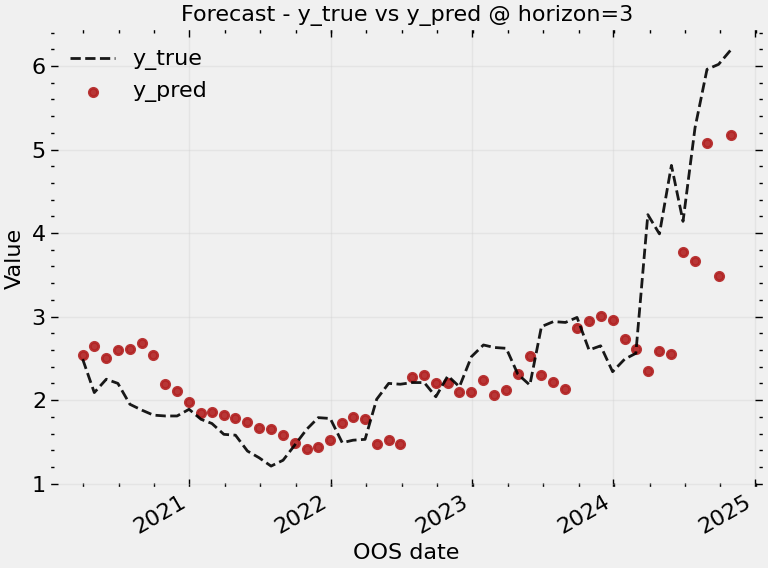

In [22]:
res.plot_actual_vs_pred(horizon=3)

## 6. Where to go next

- Swap `mdl_name` to other registered models (or register your own) and reuse the same evaluation cells.
- Increase `horizon` or adjust `ctx_len` to study the impact on Moirai vs. ARModel.
- Pipe `ForecastOutput.df_preds` into your favorite analysis toolkit.